Initial look at tick gene expression data.
This notebook looks at clustering of samples by gene counts to assess batch effects and then tries to do differential expression over the continuous variable blood meal hour to see how gene expression changes during the course of a meal. 

tl;dr: there are some insurmountable batch effects and continuous differential expression doesn't work.

## notebook set up

In [1]:
setwd("..")

In [2]:
# adjust plot size rendered inline
options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res = 300)

In [3]:
library(tidyverse, warn.conflicts = F)
library(edgeR, warn.conflicts = F)
library(ggrepel, warn.conflicts = F)

── Attaching core tidyverse packages ─────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: limma

Warning message:
“package ‘ggrepel’ was built under R version 4.3.1”


## read in counts

In [4]:
counts <- read_tsv("outputs/counts/raw_counts.tsv", show_col_types = F)
counts_summary <- counts %>% filter(grepl("^__", gene)) # keep the summary rows produced by htseq
counts <- counts %>% filter(!grepl("^__", gene)) # filter out summary rows produced by htseq

In [5]:
tail(counts_summary)

gene,Solexa-205940,Solexa-205939,Solexa-205930,Solexa-205932,Solexa-205941,Solexa-206001,Solexa-205931,Solexa-205942,AmbamSG7-11d,⋯,Ecoli_24h_3,Ecoli_24h_2,Ecoli_3h_2,Ecoli_3h_1,Um,Uf,Im,If,NEm,NEf
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
__no_feature,5651243,7055937,6522683,8289449,8304305,9389266,7406918,7982514,17197710,⋯,12617832,13512473,12139301,11048466,18975840,16508504,17737838,16413354,19718477,13795166
__ambiguous,18462,22008,19051,24339,27388,29952,21196,26880,43334,⋯,92110,86274,73109,59828,34056,28274,26081,27620,38555,23473
__too_low_aQual,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
__not_aligned,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
__alignment_not_unique,1629581,2027564,2046202,2568916,2413127,2988888,2279302,2325474,5509445,⋯,3496059,3603978,3696371,3648734,6517102,6330629,6724627,9142048,7097592,5653017


## calculate percent mapping

im not sure how to count "__alignment_not_unique," but counting each as a read, we currently get low mapping rates. This is disappointing. We might need to do something like cufflinks with the reference genome to improve this, or revisit isoform clustering by read mapping at a future date.

In [6]:
sums <- colSums(counts[, -1])
sums2 <- colSums(counts_summary[,-1])

In [7]:
sums

Solexa-205940  Solexa-205939  Solexa-205930  Solexa-205932  Solexa-205941 
       1930365        2405526        2276070        2865981        2855734 
 Solexa-206001  Solexa-205931  Solexa-205942   AmbamSG7-11d AmbamSG72-144h 
       2936202        2549457        2827339        7131686        7914394 
AmbameSG12-18h   AmbamSGunfed           PL17            PL3            PL2 
       5236959        6030717          13472          96227         110800 
           PL1           AAFM           AAUM           AAFF           AAUF 
        115426           6400          11161           8101           7301 
         MG120           MG96           MG48          SG120           SG96 
          8377           4096           5208           7123           9303 
          SG48    Ecoli_24h_1    Ecoli_12h_3    Ecoli_12h_2    Ecoli_12h_1 
         11243        5119082        4922698        4622592        4725147 
    Ecoli_6h_3     Ecoli_6h_2     Ecoli_6h_1      PBS_24h_3      PBS_24h_2 
       4966079        5083903        5042802        5335866        5619071 
     PBS_24h_1      PBS_12h_3     Ecoli_3h_3      PBS_12h_2      PBS_12h_1 
       4793091        5173217        4491560        5341489        5632622 
      PBS_6h_3       PBS_6h_2       PBS_6h_1       PBS_3h_3       PBS_3h_2 
       5433344        5084154        5412106        5363862        5385382 
   Ecoli_24h_3    Ecoli_24h_2     Ecoli_3h_2     Ecoli_3h_1             Um 
       5121587        5453411        4874923        4215060        8684513 
            Uf             Im             If            NEm            NEf 
       7589434        7920166        7699015        8784247        6166845

In [8]:
sums/sums2

Solexa-205940  Solexa-205939  Solexa-205930  Solexa-205932  Solexa-205941 
     0.2644594      0.2641836      0.2650311      0.2633519      0.2657777 
 Solexa-206001  Solexa-205931  Solexa-205942   AmbamSG7-11d AmbamSG72-144h 
     0.2366358      0.2626298      0.2735728      0.3134740      0.3175975 
AmbameSG12-18h   AmbamSGunfed           PL17            PL3            PL2 
     0.4078712      0.2262013      0.3005466      0.2982100      0.2953737 
           PL1           AAFM           AAUM           AAFF           AAUF 
     0.4013701      0.3990523      0.2897907      0.3760735      0.3228388 
         MG120           MG96           MG48          SG120           SG96 
     0.2913334      0.2444935      0.2740908      0.2770194      0.3342675 
          SG48    Ecoli_24h_1    Ecoli_12h_3    Ecoli_12h_2    Ecoli_12h_1 
     0.3126790      0.3181943      0.3123264      0.2998753      0.3022886 
    Ecoli_6h_3     Ecoli_6h_2     Ecoli_6h_1      PBS_24h_3      PBS_24h_2 
     0.3129344      0.3145830      0.2988691      0.3111904      0.3151710 
     PBS_24h_1      PBS_12h_3     Ecoli_3h_3      PBS_12h_2      PBS_12h_1 
     0.3097994      0.3136626      0.2858826      0.3432268      0.3308283 
      PBS_6h_3       PBS_6h_2       PBS_6h_1       PBS_3h_3       PBS_3h_2 
     0.3172022      0.3269128      0.3262217      0.3065425      0.2985471 
   Ecoli_24h_3    Ecoli_24h_2     Ecoli_3h_2     Ecoli_3h_1             Um 
     0.3160303      0.3170086      0.3064297      0.2856307      0.3402089 
            Uf             Im             If            NEm            NEf 
     0.3318887      0.3234233      0.3009424      0.3271037      0.3167088

## plot a PCA MDS

To get an initial picture of how similar different samples are to one another.
From this plot, we see that the E. coli treated samples and the cell line samples are each clustered very tightly.
It's impossible to know whether this is from batch effects or from biological signal.
For the E. coli samples, since these are unfed whole ticks, it's likely this is from batch effects given that the PBS controls do not cluster with the other unfed whole female ticks, but it could be from some other unobserved biological factor.
In any case, it makes sense to remove these samples before doing further analysis.

Similarly, since this notebook focuses on blood meal hour, it makes sense to remove the cell line samples.

In [9]:
y <- DGEList(counts = counts)
y <- calcNormFactors(y)

Setting first column of `counts` as gene annotation.



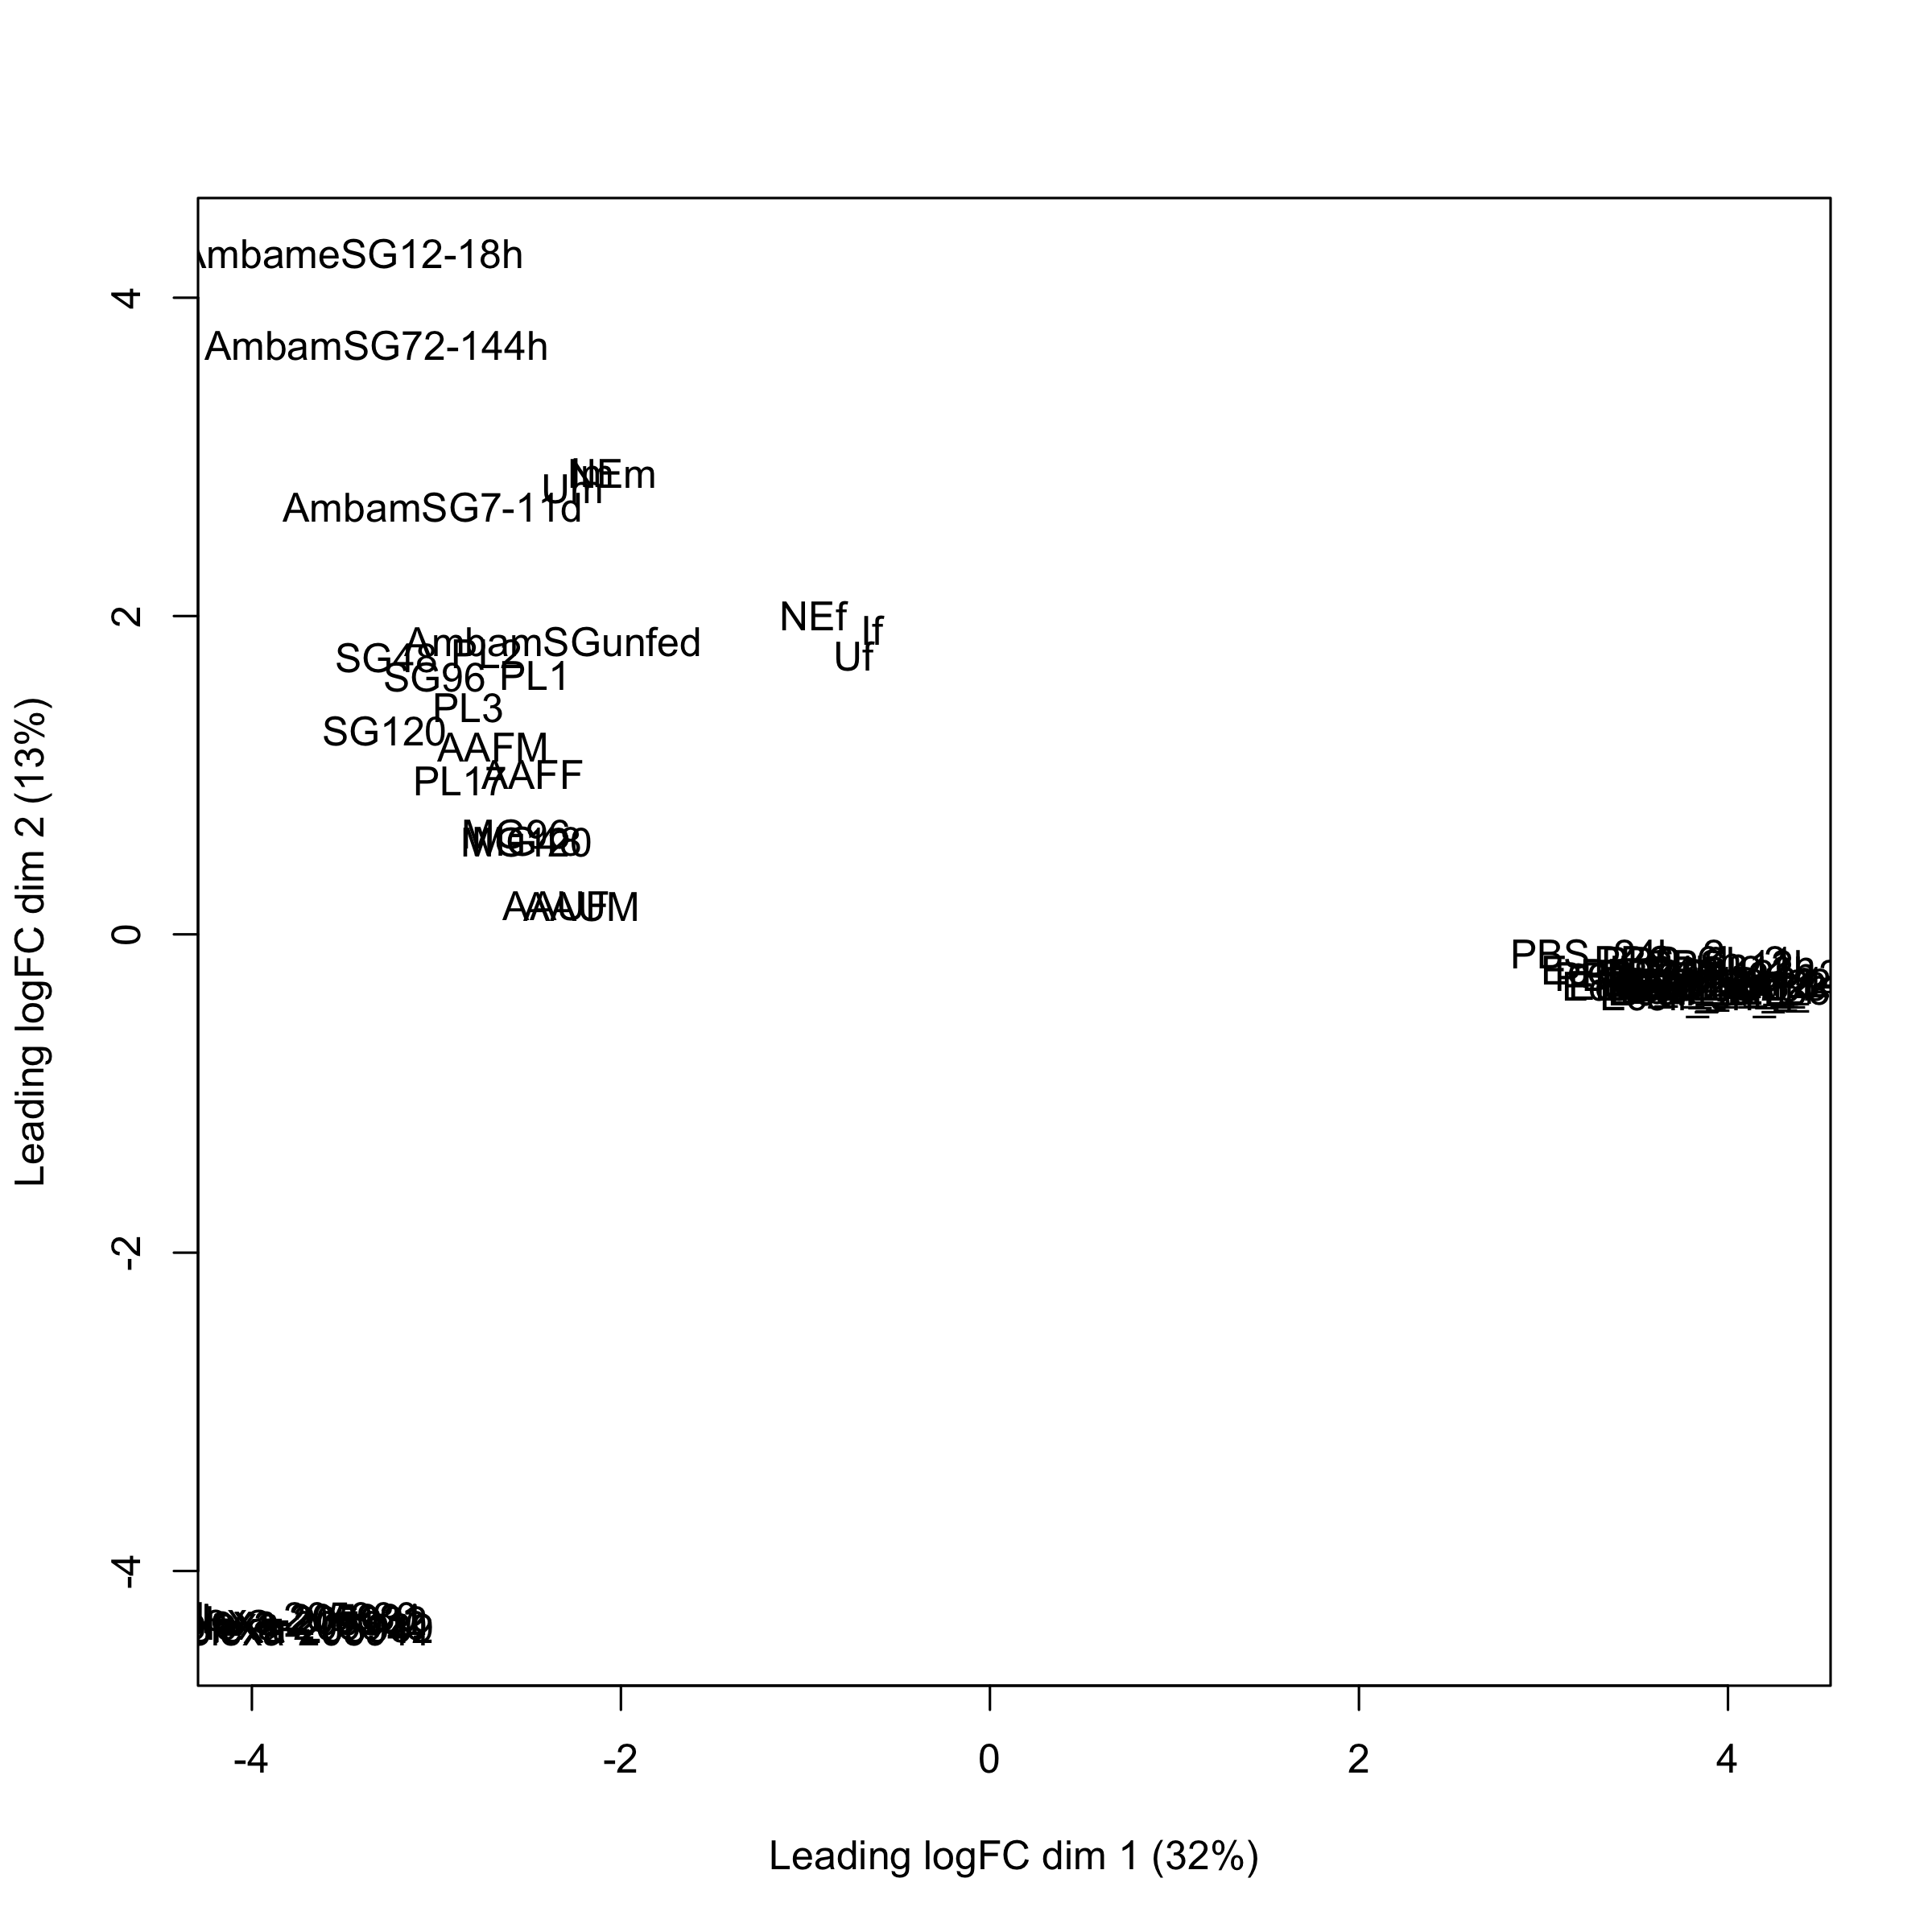

In [10]:
plotMDS(y)

## read in and format metadata

In [11]:
metadata <- read_tsv("inputs/metadata.tsv", show_col_types = F) %>%
  select(library_name, experiment_title, study_title, sex, host_meal, tissue, blood_meal_hour, blood_meal_hour_range, total_spots) %>%
  group_by(library_name) %>%
  mutate(total_spots = sum(total_spots)) %>%
  mutate(blood_meal_hour_range = factor(blood_meal_hour_range, levels = c("0", "12_48", "72_144", "168_264"))) %>%
  mutate(blood_meal_hour = as.numeric(gsub(";.*", "", blood_meal_hour))) %>% # also pick first time in samples that represent multiple times
  distinct()

## read in and format gene annotation data

In [12]:
# annotations downloaded from S3 from Emily's annotation repo outputs
# 2023-protein-data-curation/chelicerate-analysis/25aacutoff_fullset_100223/annotated/Amblyomma-americanum_combined.tsv
# the gsub commands return the gene names back to their original names
annotations <- read_tsv("inputs/Amblyomma-americanum_combined.tsv", show_col_types = F) %>%
  mutate(gene = gsub("Amblyomma-americanum_", "", gene_name), .after = gene_name) %>%
  mutate(gene = gsub("-", "_", gene))

## differential expression: functions

In [13]:
lmfit_diffex <- function(counts, continuous_variable, annotations){
  # where counts are the gene counts
  # and continuous_variablee is the continuous variable in the same order as the samples in counts to use for differential expression
  d0  <- DGEList(counts)                         # initialize the DGE object
  d   <- calcNormFactors(d0)                     # calculate normalization factors
  mm  <- model.matrix(~continuous_variable)      # build model matrix
  y   <- voom(d, mm, plot = F)                   # run voom
  fit <- lmFit(y, mm)                            # perform lm fit
    
  # test with blood mean. hour as coefficient 
  con <- contrasts.fit(fit, coefficients = 2)   
  b <- eBayes(con)
  top <- topTable(b, sort.by = "logFC", number = Inf)
  
  # join to annotations
  top_annot <- top %>%
    rownames_to_column("gene") %>%
    mutate(logFC_adj = logFC * (max(continuous_variable) - min(continuous_variable))) %>%
    left_join(annotations, by = "gene") %>%
    arrange(desc(abs(logFC_adj)))
    
  # filter to statistically and biologically significant results
  top_sig_annot <- top_annot %>%
    filter(adj.P.Val < 0.05) %>%
    filter(abs(logFC_adj) > 1)
  
  lcpm <- cpm(d, log = T)
    
  return(list(y = y, all_annot = top_annot, top_sig_annot = top_sig_annot, lcpm = lcpm))
}

In [22]:
# plot gene count lm

plot_gene_count_lm <- function(gene, metadata, voom_model){
  Y <- voom_model$E[gene, ]
  # add corrected gene counts to metadata data frame
  metadata$Y = Y
  
  ggplot(metadata, aes(y = Y, x = blood_meal_hour, label = library_name)) +
    geom_point(color = "black", alpha = .7) +
    labs(y = "norm log counts", x = "blood meal hour") +
    theme_minimal() +
    geom_smooth(method='lm', color = "grey", alpha = .7, se= F) +
    ggrepel::geom_label_repel()
}

## differential expression: blood meal hour with most samples

cell line samples, samples treated with E. coli, and samples exposed to E. chaf have been removed for this trial analysis.

In [15]:
metadata_blood_meal <- metadata %>%
  filter(!is.na(blood_meal_hour)) %>% # filter out samples that don't have blood meal hour (cell lines)
  filter(!study_title %in% "Amblyomma americanum RNA-seq following E. coli treatment") %>% # rm e. coli study, too batched
  filter(!library_name %in% c("Um", "Uf", "Im", "If")) # filter e chaf exposed samples

In [16]:
metadata_blood_meal

library_name,experiment_title,study_title,sex,host_meal,tissue,blood_meal_hour,blood_meal_hour_range,total_spots
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>,<dbl>
AmbamSG7-11d,Salivary gland transcriptome of adult female Amblyomma americanum ticks fed for 7-11 days,Amblyomma americanum adult female salivary gland transcriptome,female,sheep,salivary_gland,168,168_264,44443612
AmbamSG72-144h,Salivary gland transcriptome of adult female Amblyomma americanum ticks fed for 72-144 hours,Amblyomma americanum adult female salivary gland transcriptome,female,sheep,salivary_gland,72,72_144,49791091
AmbameSG12-18h,Salivary gland transcriptome of adult female Amblyomma americanum ticks fed for 12-48 hours,Amblyomma americanum adult female salivary gland transcriptome,female,sheep,salivary_gland,12,12_48,25095072
AmbamSGunfed,Salivary glands transcriptome of unfed adult female Amblyomma americanum ticks,Amblyomma americanum adult female salivary gland transcriptome,female,unfed,salivary_gland,0,0,53124914
PL17,Fed Males,Amblyomma americanum strain:Stillwater Oklahoma Transcriptome or Gene expression,male,rabbit,whole,72,72_144,413856
PL3,Fed males,Amblyomma americanum strain:Stillwater Oklahoma Transcriptome or Gene expression,male,rabbit,whole,72,72_144,850276
PL2,4 day fed females,Amblyomma americanum strain:Stillwater Oklahoma Transcriptome or Gene expression,female,rabbit,whole,96,72_144,1031591
PL1,24h fed female,Amblyomma americanum strain:Stillwater Oklahoma Transcriptome or Gene expression,female,rabbit,whole,24,12_48,740878
AAFM,Fed Male Whole Tick,Amblyomma americanum strain:Stillwater Oklahoma Transcriptome or Gene expression,male,rabbit,whole,72,72_144,50887


In [17]:
# select only columns that have blood meal hour as a metadata point
counts_blood_meal <- counts %>%
  dplyr::select(c(gene, metadata_blood_meal$library_name)) %>%
  as.data.frame() %>%
  column_to_rownames("gene")

# reorder metadata_blood_meal to match order of counts_blood_meal
metadata_blood_meal <- metadata_blood_meal[order(match(metadata_blood_meal$library_name, colnames(counts_blood_meal))), ]

In [18]:
bmh <- lmfit_diffex(counts = counts_blood_meal, 
                    continuous_variable = metadata_blood_meal$blood_meal_hour, 
                    annotations = annotations)

In [19]:
nrow(bmh$all_annot)
nrow(bmh$top_sig_annot)

[1] 34557

[1] 0

**plot gene with largest l2fc and see what it looks like**

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“The following aesthetics were dropped during statistical transformation: label
ℹ This can happen when ggplot fails to infer the correct grouping structure in the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical variable into a factor?”


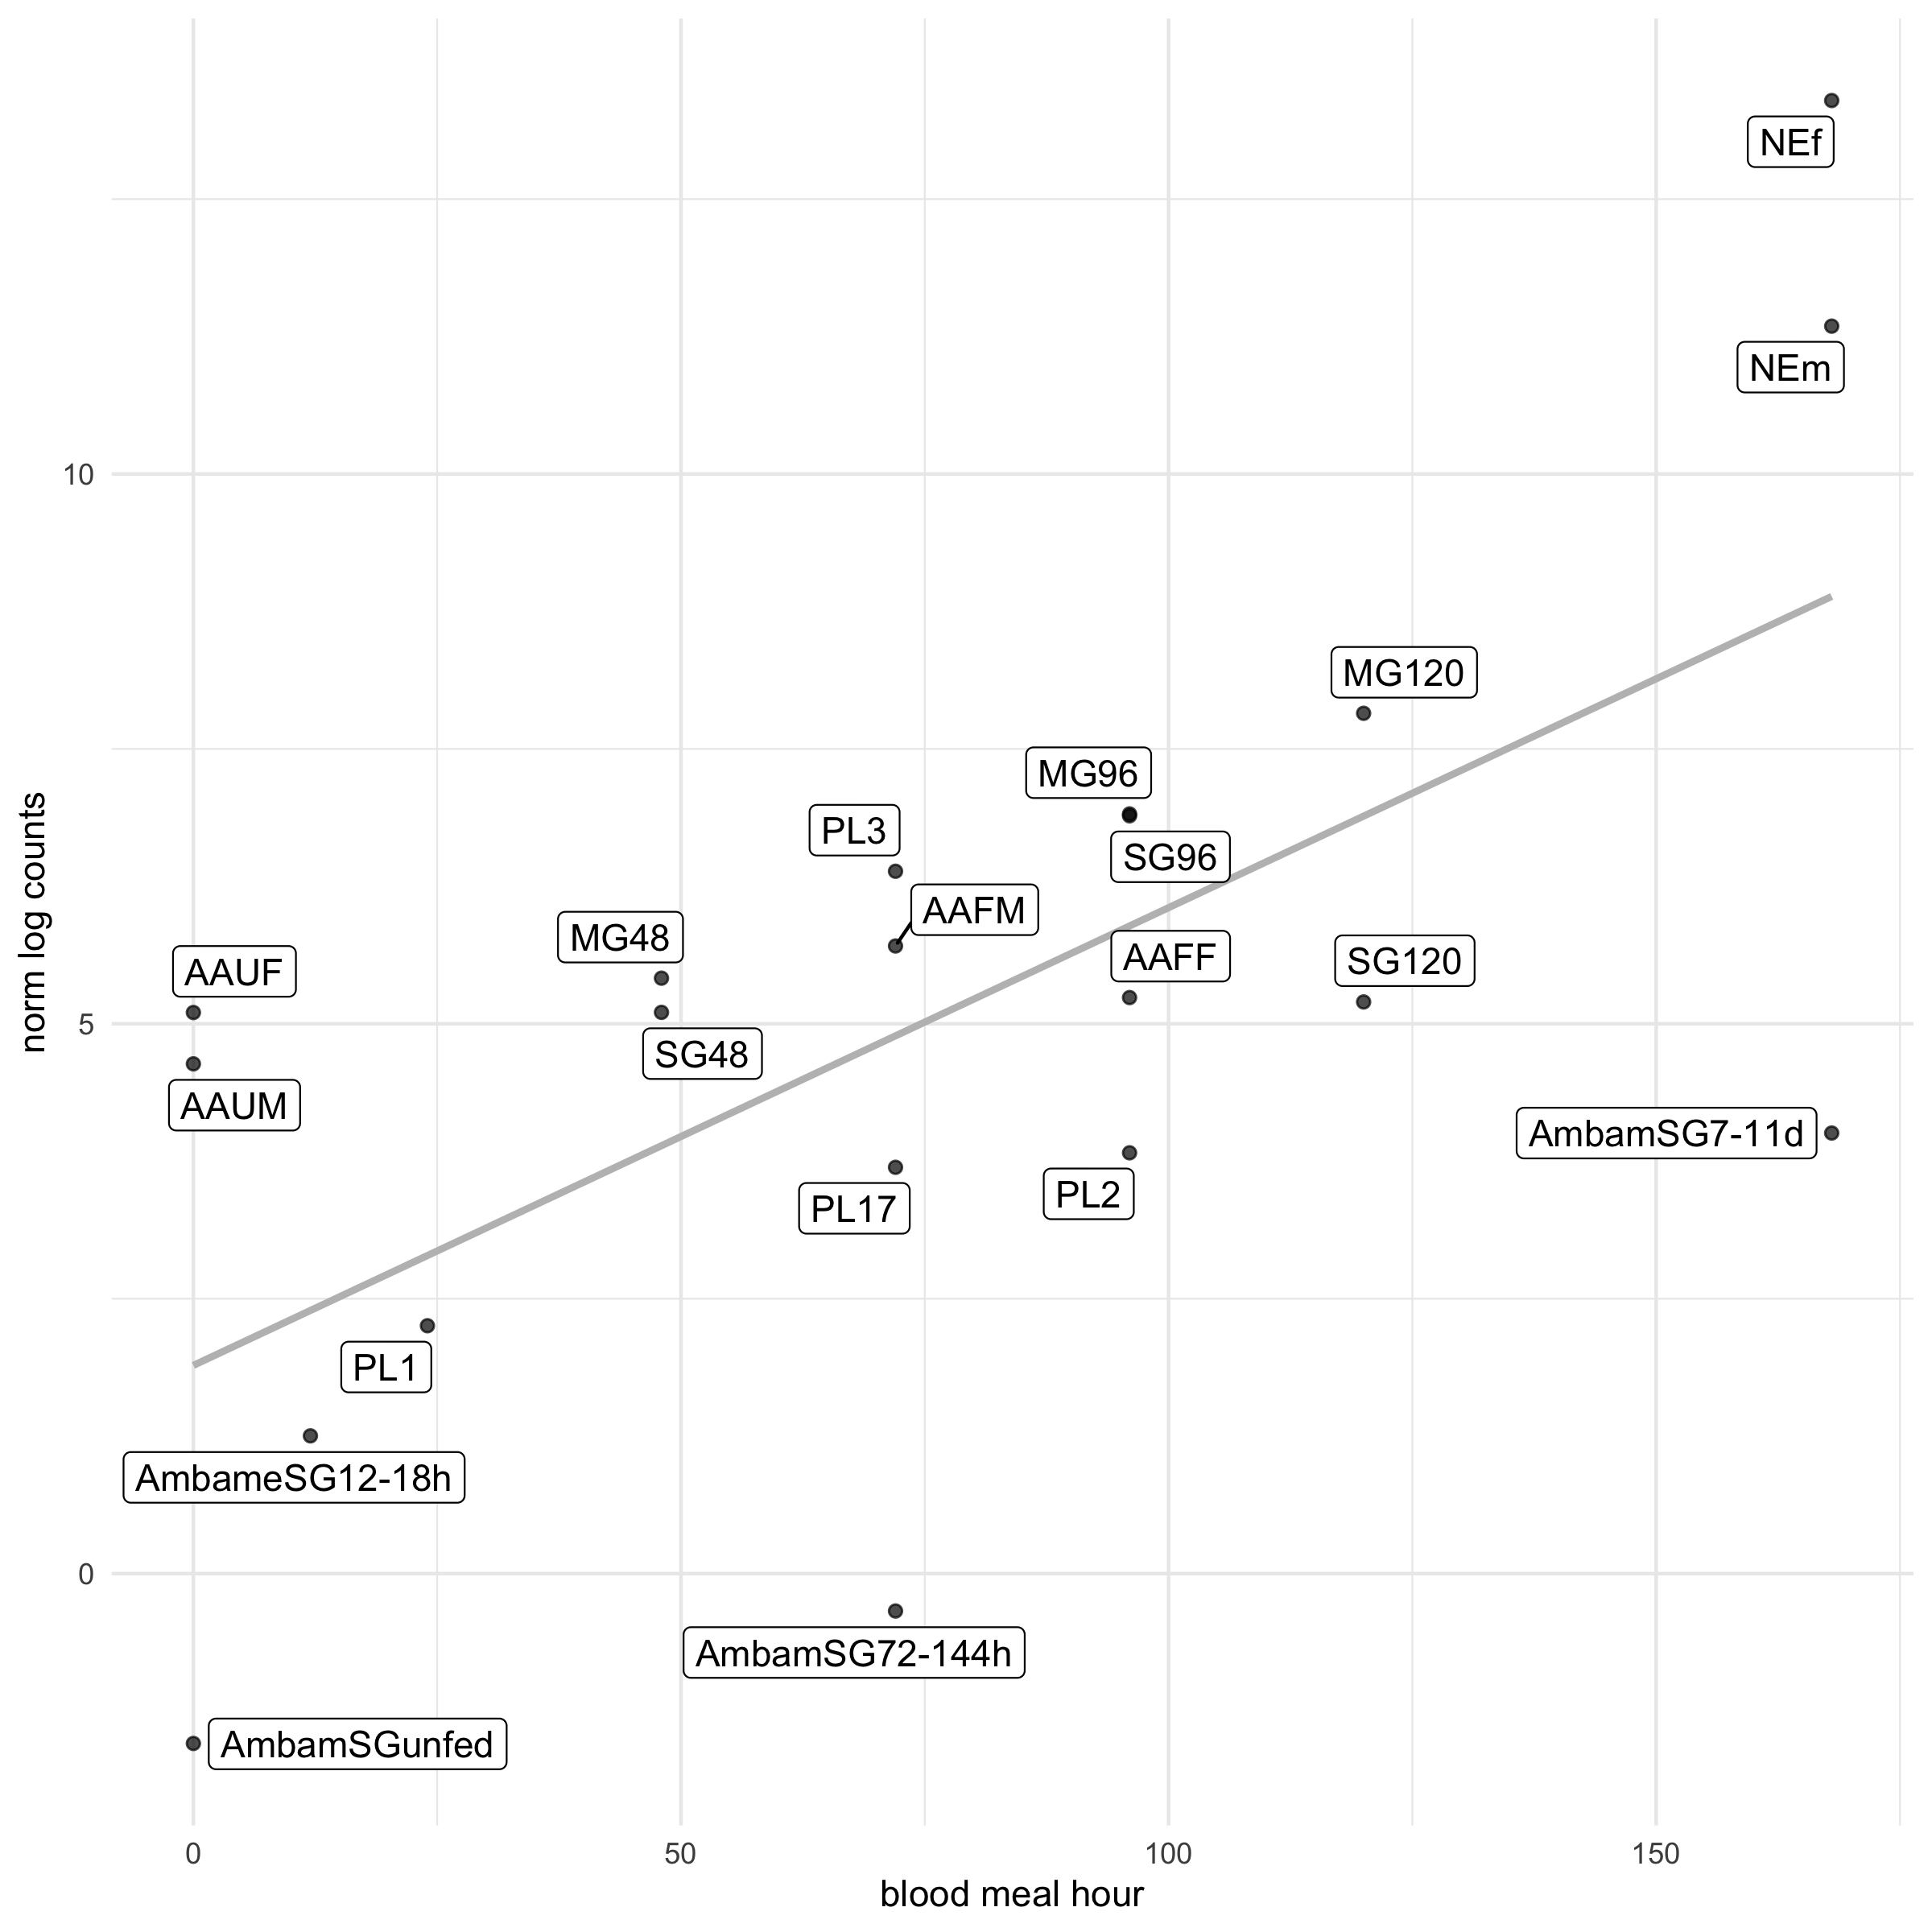

In [23]:
plot_gene_count_lm(gene = "evm.model.contig_74103_1.2", 
                   metadata = metadata_blood_meal, 
                   voom_model = bmh$y)

**summary of first differential expression experiment**: This first experiment produced no significantly differentially expressed genes. This indicates that there are not conserved patterns of expression during the blood meal that overcome the variables study, tissue, and sex.

My next step is to perform differential expression again, but this time to subset the samples further. I'll first try separating my tissue type, and then by sex, and then lastly by study.

## differential expression: blood meal hour by tissue type (whole, midgut, salivary gland)

### salivary gland

In [21]:
metadata_blood_meal_sg <- metadata %>%
  filter(!is.na(blood_meal_hour)) %>% # filter out samples that don't have blood meal hour (cell lines)
  filter(tissue == "salivary_gland")

In [24]:
metadata_blood_meal_sg # this filter automatically limits us to female only

library_name,experiment_title,study_title,sex,host_meal,tissue,blood_meal_hour,blood_meal_hour_range,total_spots
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>,<dbl>
AmbamSG7-11d,Salivary gland transcriptome of adult female Amblyomma americanum ticks fed for 7-11 days,Amblyomma americanum adult female salivary gland transcriptome,female,sheep,salivary_gland,168,168_264,44443612
AmbamSG72-144h,Salivary gland transcriptome of adult female Amblyomma americanum ticks fed for 72-144 hours,Amblyomma americanum adult female salivary gland transcriptome,female,sheep,salivary_gland,72,72_144,49791091
AmbameSG12-18h,Salivary gland transcriptome of adult female Amblyomma americanum ticks fed for 12-48 hours,Amblyomma americanum adult female salivary gland transcriptome,female,sheep,salivary_gland,12,12_48,25095072
AmbamSGunfed,Salivary glands transcriptome of unfed adult female Amblyomma americanum ticks,Amblyomma americanum adult female salivary gland transcriptome,female,unfed,salivary_gland,0,0,53124914
SG120,Female Salivary Gland 120h fed,Amblyomma americanum strain:Stillwater Oklahoma Transcriptome or Gene expression,female,rabbit,salivary_gland,120,72_144,67277
SG96,Female Salivary Gland 96h fed,Amblyomma americanum strain:Stillwater Oklahoma Transcriptome or Gene expression,female,rabbit,salivary_gland,96,72_144,86616
SG48,Female Salivary Gland 48h fed,Amblyomma americanum strain:Stillwater Oklahoma Transcriptome or Gene expression,female,rabbit,salivary_gland,48,12_48,179494


In [25]:
# select only columns that have blood meal hour as a metadata point
counts_blood_meal_sg <- counts %>%
  dplyr::select(c(gene, metadata_blood_meal_sg$library_name)) %>%
  as.data.frame() %>%
  column_to_rownames("gene")

# reorder metadata_blood_meal to match order of counts_blood_meal
metadata_blood_meal_sg <- metadata_blood_meal_sg[order(match(metadata_blood_meal_sg$library_name, colnames(counts_blood_meal_sg))), ]

In [26]:
bmh_sg <- lmfit_diffex(counts = counts_blood_meal_sg, 
                       continuous_variable = metadata_blood_meal_sg$blood_meal_hour, 
                       annotations = annotations)

In [27]:
nrow(bmh_sg$top_sig_annot)
head(bmh_sg$all_annot)

min(bmh_sg$all_annot$adj.P.Val, na.rm = T)

[1] 0

,gene,logFC,AveExpr,t,P.Value,adj.P.Val,B,logFC_adj,gene_name,egg_seed_ortholog,⋯,KO_thrshld,KO_score,KO_E-value,KO_definition,deepsig_feature,deepsig_start,deepsig_end,deepsig_sp_score,deepsig_sp_evidence,Length
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,evm.model.contig_93834_1.1,0.08135558,2.671718,2.988047,0.0120773649,0.8311876,-2.7634268,13.66774,Amblyomma-americanum_evm.model.contig-93834-1.1,NA,⋯,981.80;957.50;748.47;943.53;767.27,191.0;151.9;149.4;130.7;99.8,5.8e-56;2.7e-44;1.9e-43;1e-37;2e-28,neprilysin [EC:3.4.24.11];endothelin-converting enzyme [EC:3.4.24.71];endothelin-converting enzyme-like 1 [EC:3.4.24.-];neprilysin [EC:3.4.24.11];phosphate-regulating neutral endopeptidase [EC:3.4.24.-],Signal peptide,1,23,1.0,evidence=ECO:0000256,1118
2,evm.model.contig_146682_1.2,0.07972087,6.103864,3.730750,0.0032019081,0.8311876,-1.8712698,13.39311,Amblyomma-americanum_evm.model.contig-146682-1.2,NA,⋯,981.8;957.5;767.27;670.1,30.9;26.2;19.9;13.5,1.4e-07;2.3e-06;0.00031;0.023,neprilysin [EC:3.4.24.11];endothelin-converting enzyme [EC:3.4.24.71];phosphate-regulating neutral endopeptidase [EC:3.4.24.-];Kell blood group glycoprotein [EC:3.4.24.-],Chain,1,145,.,evidence=ECO:0000256,145
3,evm.model.contig_23543_1.1,0.07960907,2.607736,3.595084,0.0040688843,0.8311876,-1.7420531,13.37432,Amblyomma-americanum_evm.model.contig-23543-1.1,NA,⋯,235.4;265.7,28.6;13.1,1.3e-06;0.062,tissue factor pathway inhibitor 2;tissue factor pathway inhibitor,Signal peptide,1,26,0.92,evidence=ECO:0000256,167
4,evm.model.contig_194067_1.1,-0.07920484,4.470824,-3.854474,0.0025773445,0.8311876,-1.3485149,-13.30641,Amblyomma-americanum_evm.model.contig-194067-1.1,NA,⋯,NA,NA,NA,NA,Chain,1,82,.,evidence=ECO:0000256,82
5,evm.model.contig_85352_1.2,0.07448906,4.590398,5.225313,0.0002640253,0.8311876,0.7315935,12.51416,Amblyomma-americanum_evm.model.contig-85352-1.2,NA,⋯,NA,NA,NA,NA,Signal peptide,1,19,0.99,evidence=ECO:0000256,176
6,evm.model.contig_61708_1.1,0.07375575,4.841148,5.005035,0.0003742938,0.8311876,0.4058599,12.39097,Amblyomma-americanum_evm.model.contig-61708-1.1,NA,⋯,216.03;235.4;109.37;265.7;262.23,18.1;17.4;16.4;15.2;14.8,0.0023;0.0033;0.0099;0.015;0.013,"WAP four-disulfide core domain protein 6;tissue factor pathway inhibitor 2;Kunitz-type protease inhibitor 3;tissue factor pathway inhibitor;WAP, Kazal, immunoglobulin, Kunitz and NTR domain-containing protein",Signal peptide,1,16,1.0,evidence=ECO:0000256,76


[1] 0.8311876

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“The following aesthetics were dropped during statistical transformation: label
ℹ This can happen when ggplot fails to infer the correct grouping structure in the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical variable into a factor?”


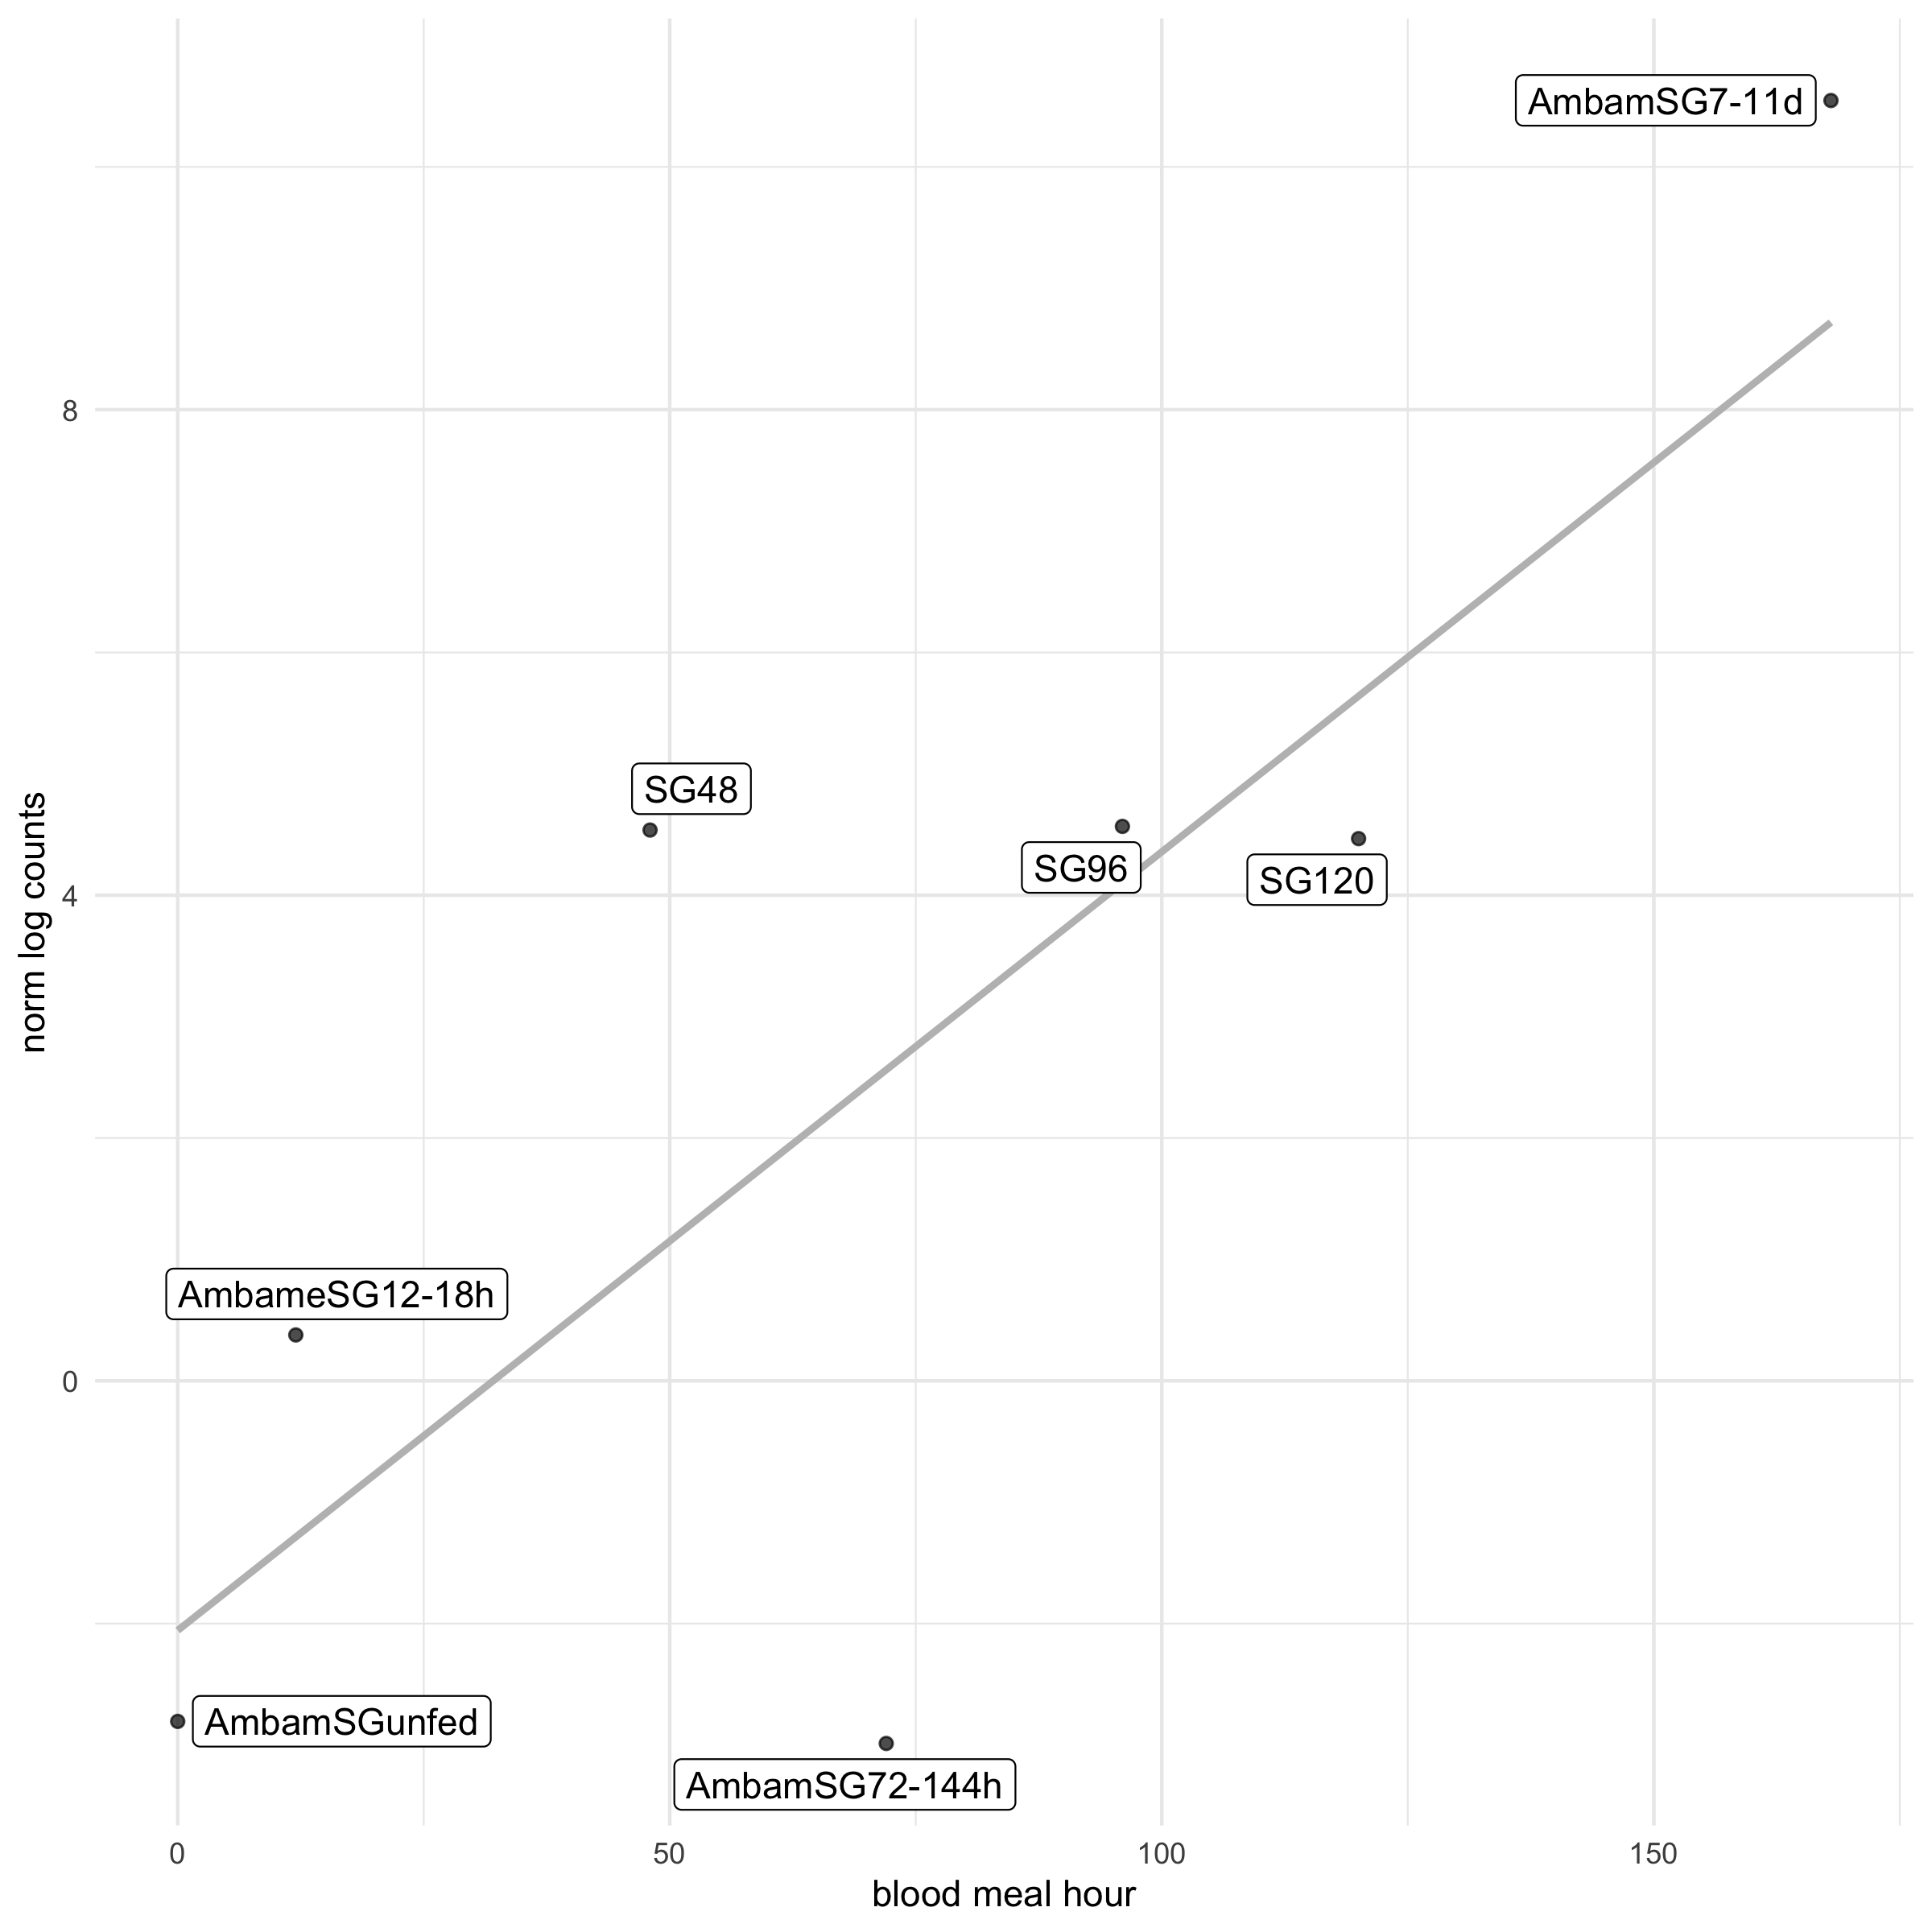

In [28]:
plot_gene_count_lm(gene = "evm.model.contig_93834_1.1", 
                   metadata = metadata_blood_meal_sg, 
                   voom_model = bmh_sg$y)

Annoyingly, no differentially expressed genes again. The samples that start with SG have a really small number of reads (less than 10k) which might be causing some of the issues. I'll try for whole tick next.

### whole tick

In [29]:
metadata_blood_meal_whole <- metadata %>%
  filter(!is.na(blood_meal_hour)) %>% # filter out samples that don't have blood meal hour (cell lines)
  filter(tissue == "whole") %>%
  filter(!study_title %in% "Amblyomma americanum RNA-seq following E. coli treatment") %>% # rm e. coli study, too batched
  filter(!library_name %in% c("Um", "Uf", "Im", "If")) # filter e chaf exposed samples

In [30]:
# select only columns that have blood meal hour as a metadata point
counts_blood_meal_whole <- counts %>%
  dplyr::select(c(gene, metadata_blood_meal_whole$library_name)) %>%
  as.data.frame() %>%
  column_to_rownames("gene")

# reorder metadata_blood_meal to match order of counts_blood_meal
metadata_blood_meal_whole <- metadata_blood_meal_whole[order(match(metadata_blood_meal_whole$library_name, colnames(counts_blood_meal_whole))), ]

In [31]:
bmh_whole <- lmfit_diffex(counts = counts_blood_meal_whole, 
                          continuous_variable = metadata_blood_meal_whole$blood_meal_hour, 
                          annotations = annotations)

In [32]:
nrow(bmh_whole$top_sig_annot)
head(bmh_whole$all_annot)

min(bmh_whole$all_annot$adj.P.Val, na.rm = T)

[1] 17765

,gene,logFC,AveExpr,t,P.Value,adj.P.Val,B,logFC_adj,gene_name,egg_seed_ortholog,⋯,KO_thrshld,KO_score,KO_E-value,KO_definition,deepsig_feature,deepsig_start,deepsig_end,deepsig_sp_score,deepsig_sp_evidence,Length
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,evm.model.contig_63237_1.2,-0.05126611,3.604193,-5.309115,1.102433e-07,1.796647e-05,7.025830,-8.612706,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,evm.model.contig_63231_1.2,-0.04998220,3.733739,-5.058489,4.228603e-07,1.796647e-05,5.755905,-8.397010,Amblyomma-americanum_evm.model.contig-63231-1.2,NA,⋯,NA,NA,NA,NA,Signal peptide,1,19,0.98,evidence=ECO:0000256,208
3,evm.model.contig_187387_1.1,-0.04979593,3.184553,-5.407948,6.380349e-08,1.796647e-05,7.515565,-8.365716,Amblyomma-americanum_evm.model.contig-187387-1.1,NA,⋯,NA,NA,NA,NA,Chain,1,93,.,evidence=ECO:0000256,93
4,evm.model.contig_21077_1.3,-0.04920598,3.026057,-5.439991,5.332833e-08,1.796647e-05,7.674545,-8.266604,Amblyomma-americanum_evm.model.contig-21077-1.3,NA,⋯,NA,NA,NA,NA,Chain,1,74,.,evidence=ECO:0000256,74
5,evm.model.contig_235214_1.6,-0.04871648,3.110857,-5.350219,8.791754e-08,1.796647e-05,7.199193,-8.184369,Amblyomma-americanum_evm.model.contig-235214-1.6,7029.ACYPI062806-PA,⋯,NA,NA,NA,NA,Signal peptide,1,30,0.91,evidence=ECO:0000256,167
6,evm.model.contig_74103_1.2,0.04746108,6.442774,4.277263,1.892685e-05,6.111524e-05,2.236420,7.973462,Amblyomma-americanum_evm.model.contig-74103-1.2,NA,⋯,324.50;841.37,6.1;4.1,9.5;19,squid;podocan-like protein 1,Signal peptide,1,18,0.85,evidence=ECO:0000256,301


[1] 1.796647e-05

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“The following aesthetics were dropped during statistical transformation: label
ℹ This can happen when ggplot fails to infer the correct grouping structure in the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical variable into a factor?”


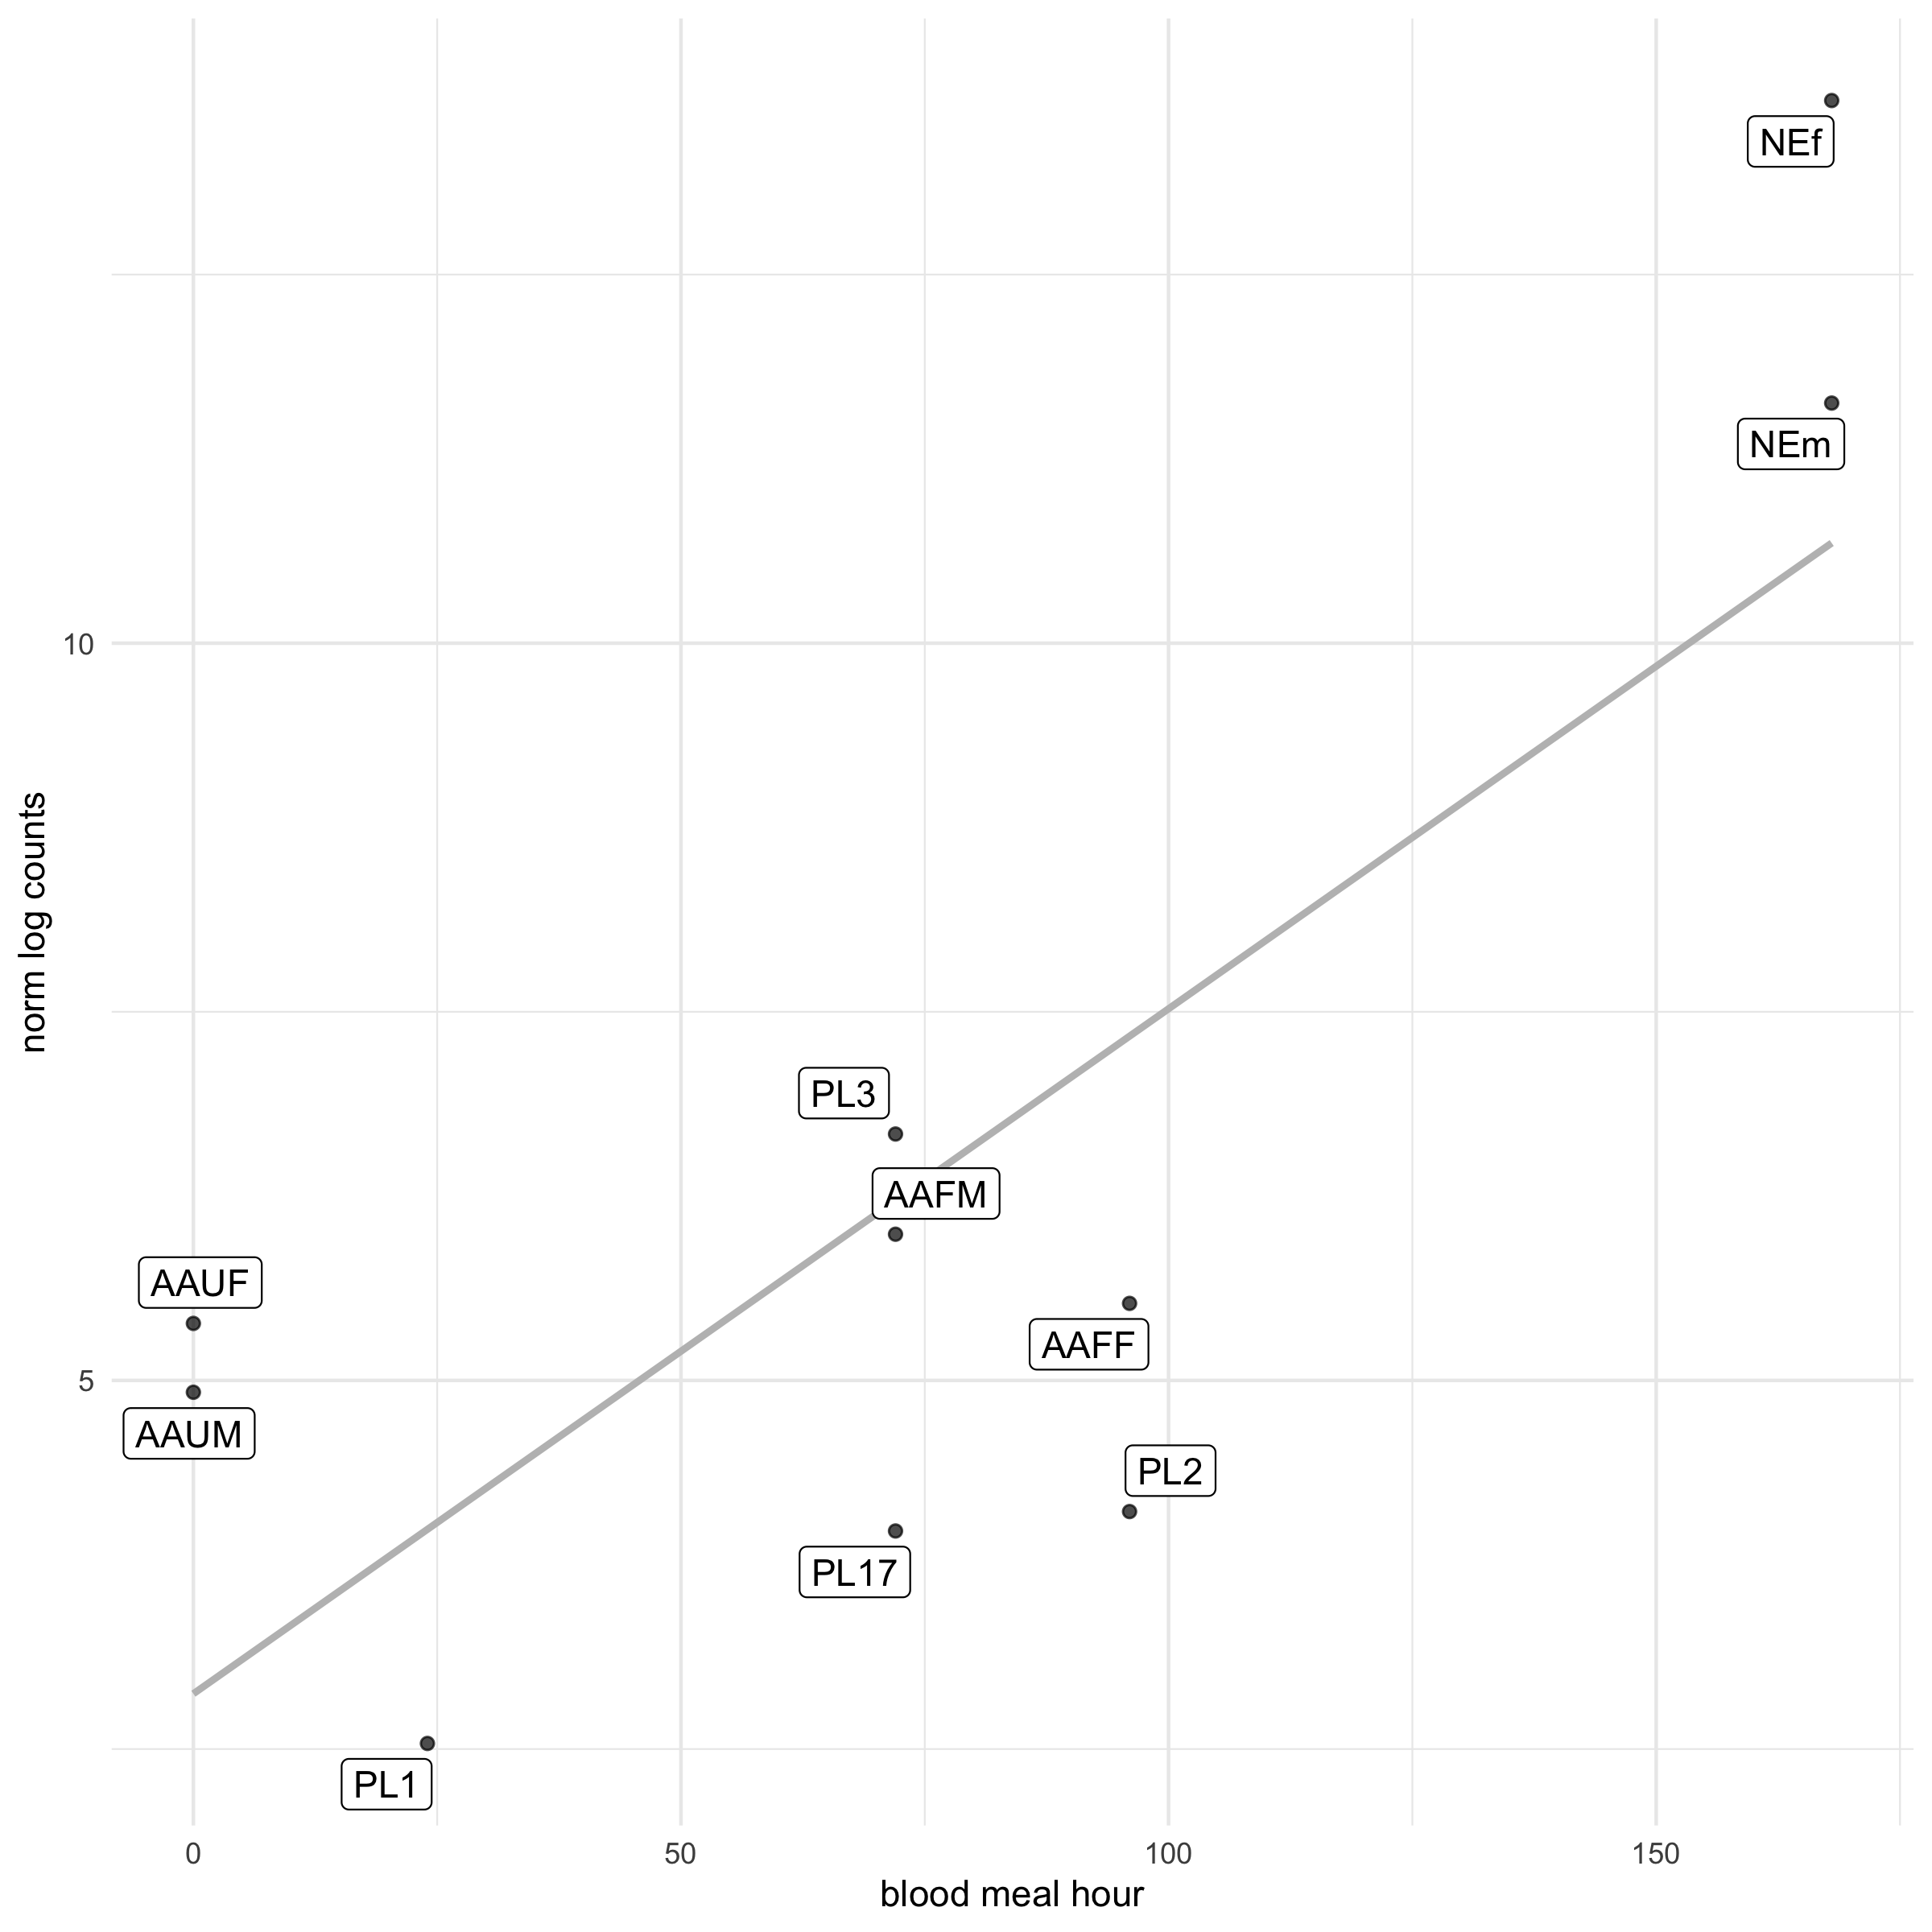

In [33]:
plot_gene_count_lm(gene = "evm.model.contig_74103_1.2", 
                   metadata = metadata_blood_meal_whole, 
                   voom_model = bmh_whole$y)

I mean at least we get differentially expressed genes here.
All the samples except `NEm` and `NEf` are from the same study too, so at least the first part of the experiment has fewer batch effects.
But...for the gene with the lowest p value and highest log2fc, this isn't particularly believable. 

## Conclusion

I am displeased with the results of continuous differential expression. We either don't have enough samples, have too strong of batch effects, or samples that aren't deeply sequenced enough to reliably say that the patterns we detect are real with this method. Next I'll try differential expression with categorical variables.

In [34]:
sessionInfo()

R version 4.3.0 (2023-04-21)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS/LAPACK: /Users/taylorreiter/miniconda3/envs/tidyjupyter/lib/libopenblasp-r0.3.23.dylib;  LAPACK version 3.11.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/New_York
tzcode source: system (macOS)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] ggrepel_0.9.4   edgeR_3.42.4    limma_3.56.2    lubridate_1.9.2
 [5] forcats_1.0.0   stringr_1.5.0   dplyr_1.1.2     purrr_1.0.1    
 [9] readr_2.1.4     tidyr_1.3.0     tibble_3.2.1    ggplot2_3.4.2  
[13] tidyverse_2.0.0

loaded via a namespace (and not attached):
 [1] utf8_1.2.3       generics_0.1.3   stringi_1.7.12   lattice_0.21-8  
 [5] hms_1.1.3        digest_0.6.31    magrittr_2.0.3   evaluate_0.21   
 [9] grid_4.3.0       timechange_0.2.0 pbdZMQ_0.3-9     fastmap_1.1.